# Stocks data ingestion

In [1]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="./")

> 2024-03-11 13:33:49,085 [info] Project loaded successfully: {'project_name': 'stocks'}


In [2]:
#loading the number of stocks as project parameter

number_of_stocks = project.params.get('NUMBER_OF_STOCKS',0)
stocks_list = project.params.get('STOCKS_LIST','META,AMZN,GOOGL,MSFT,NFLX')

> <b> Steps </b>
>  * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
>  * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
>  * [Testing ingestion service](#Testing-ingestion-service)
>  * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta) 

## Creating a feature set and declaring the graph

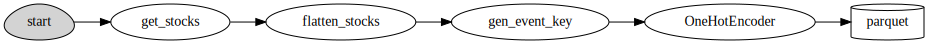

In [3]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import DateExtractor, OneHotEncoder
from mlrun.datastore.targets import ParquetTarget
import yahoo_fin.stock_info as si

info_set = fstore.FeatureSet("stocks", 
                             entities=[fstore.Entity("ticker")],
                             timestamp_key='Datetime', 
                             description="stocks feature set")

info_set.graph\
        .to(name='get_stocks',handler='get_stocks')\
        .to("storey.steps.Flatten", name="flatten_stocks")\
        .to(name='gen_event_key',handler='gen_event_key',full_event=True)\
        .to(OneHotEncoder(mapping={'ticker':{ticker:str(idx) for idx,ticker in enumerate(list(stocks_list.split(',')))}}))\
    
# Setting default targets (nosql & parquet)
info_set.set_targets([ParquetTarget(flush_after_seconds=5)], with_defaults=False) 
info_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [4]:
import os 
import datetime
# code must be present when ingestint locally
from src.stocks import *

# ingesting dummy (A MUST) 
name = 'stocks-dummy'
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

info_set.ingest(pd.DataFrame.from_dict({'ticker':[name],
                                      'Datetime': now,
                                      'start_delta':6,
                                      'end_delta':0,
                                      'interval':'5m',
                                      'n_stocks':number_of_stocks,
                                      'stocks_list':stocks_list}),
              overwrite=True)

> 2024-03-11 13:33:52,910 [info] logging run results to: http://mlrun-api:8080
> 2024-03-11 13:33:52,936 [info] getting stocks for event {'ticker': 'stocks-dummy', 'Datetime': '2024-03-11 13:33:49', 'start_delta': 6, 'end_delta': 0, 'interval': '5m', 'n_stocks': 0, 'stocks_list': 'META,AMZN,GOOGL,MSFT,NFLX'}
> 2024-03-11 13:33:53,578 [info] retrieving tickers ['META', 'AMZN', 'GOOGL', 'MSFT', 'NFLX'] history between 2024-03-05 13:33:53.578713 and 2024-03-11 13:33:53.578723 with interval 5m
> 2024-03-11 13:33:54,140 [info] finished processing stocks
> 2024-03-11 13:33:54,297 [info] getting stocks for event {'ticker': 'stocks-dummy', 'Datetime': '2024-03-11 13:33:49', 'start_delta': 6, 'end_delta': 0, 'interval': '5m', 'n_stocks': 0, 'stocks_list': 'META,AMZN,GOOGL,MSFT,NFLX'}
> 2024-03-11 13:33:54,930 [info] retrieving tickers ['META', 'AMZN', 'GOOGL', 'MSFT', 'NFLX'] history between 2024-03-05 13:33:54.929998 and 2024-03-11 13:33:54.930007 with interval 5m
> 2024-03-11 13:33:55,427 [in

,Datetime,Open,High,Low,Close,Volume,ticker_META,ticker_AMZN,ticker_GOOGL,ticker_MSFT,ticker_NFLX
ticker,,,,,,,,,,,
META,2024-03-05 13:30:00,491.105011,491.799988,490.989990,491.274994,0,1,0,0,0,0
META,2024-03-05 13:35:00,491.260010,491.579987,490.470001,490.700012,72401,1,0,0,0,0
META,2024-03-05 13:40:00,490.477997,490.518005,489.595001,489.660004,75924,1,0,0,0,0
META,2024-03-05 13:45:00,489.640015,489.933289,489.399994,489.649994,77469,1,0,0,0,0
META,2024-03-05 13:50:00,489.700012,489.890015,489.250000,489.368011,58879,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
NFLX,2024-03-08 15:40:00,602.842529,603.659973,602.739990,603.294983,30038,0,0,0,0,1
NFLX,2024-03-08 15:45:00,603.539978,605.140015,603.539978,604.640015,58792,0,0,0,0,1
NFLX,2024-03-08 15:50:00,604.690002,605.215027,603.890015,604.479980,65727,0,0,0,0,1


In [5]:
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
info_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_stocks',kind='serving',image='mlrun/mlrun', requirements=['yahoo_fin', 'yfinance', 'graphviz'], filename='src/stocks.py')

function.spec.readiness_timeout = 3600

run_config = fstore.RunConfig(function=function, local=False)

In [ ]:
# Deploying
info_set_endpoint, function = info_set.deploy_ingestion_service(run_config=run_config)

> 2024-03-11 13:33:56,121 [info] Starting remote function deploy
2024-03-11 13:33:56  (info) Deploying function
2024-03-11 13:33:56  (info) Building
2024-03-11 13:33:56  (info) Staging files and preparing base images
2024-03-11 13:33:57  (info) Building processor image


## Testing ingestion service

In [ ]:
import requests
import json

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(info_set_endpoint,json={'ticker':['stocks'],
                                                 'Datetime': now,
                                                 'start_delta':29,
                                                 'end_delta':0,
                                                 'interval':'5m',
                                                 'n_stocks':number_of_stocks,
                                                 'stocks_list':stocks_list
                                          })
t.text

## Creating scheduled mlrun job to invoke our function every time delta

In [ ]:
import datetime

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

body = {'ticker':['stocks'],
        'Datetime': now,
        'start_delta':1,
        'end_delta':0,
        'interval':'5m',
        'n_stocks':number_of_stocks,
        'stocks_list':stocks_list}

# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_stocks',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':info_set_endpoint, 'body': body}, schedule='*/10 14-18 * * *')